<a href="https://colab.research.google.com/github/JanSchering/Thesis/blob/main/ABC_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# @title install dependencies
!pip install tqdm
!pip install --upgrade -q git+https://github.com/google/flax.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 4.2 MB/s 
     |████████████████████████████████| 8.1 MB 19.6 MB/s 
     |████████████████████████████████| 237 kB 50.3 MB/s 
     |████████████████████████████████| 51 kB 6.6 MB/s 
     |████████████████████████████████| 85 kB 4.6 MB/s 


In [5]:
# @title imports
from typing import Callable, List, Tuple
import jax.numpy as jnp
from jax import lax
from jax import grad
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import Image
from IPython import display
from tqdm import tqdm
import time

# ABC for lattice models

In the following, we want to apply the [ABC](https://colab.research.google.com/drive/1duLStl8c9ngezywm6esL4K4bP49G4Jsg#scrollTo=bnLMiNi2nUqD) framework to estimating the parameters of stochastic lattice models. As an example, we consider a [probabilistic cellular automaton (PCA) for the diffusive spread of a news item](https://colab.research.google.com/drive/1xTxLeSW2BhSIMQAHUlYq8GhUafw7b85F#scrollTo=5fnWUde_LIOo).

Using the [PCA framework](https://link.springer.com/book/10.1007/978-3-319-65558-1), we define:

- The Graph $G$ to be a 2D lattice of $(K,K)$ regular cells
- The Alphabet $S:= \{0,1\}$
- The neighborhood $V_k$ of cell $k$ is the square Moore neighborhood with distance 1

The probability of reaching a configuration $\sigma \in S^{K\times K}$ from a current configuration $\mu \in S^{K\times K}$ is:

$$P(\sigma | \mu) = \prod_{k \in G} p(\sigma_k|\mu_{V_k})$$

Where we define $p(\sigma_k|\mu_{V_k})$, the probability of cell $k$ transitioning to state $\sigma_k$ given the state of its' neighborhood $\mu_{V_k}$ as:

$$p(\sigma_k|\mu_{V_k}) = \begin{pmatrix}
1 & 1-(1-\beta)^{N_k(n)} \\
0 & (1-\beta)^{N_k(n)}
\end{pmatrix}$$

The probability matrix represents, that once a person is aware of the news, they stay aware ($p_{11} = 1$, $p_{21}=0$). The probability, with which an uninformed person stays uninformed at time $n+1$ depends on the amount of local neighbors that are informed at time $n$, $N_k(n)$. Given a rate of spread $\beta$ (the diffusion coefficient), the probability to stay unaware is $p_{22}= (1-\beta)^{N_k(n)}$. Conversely, the probability that the news spread to cell $k$ is $p_{21} = 1 - p_{22} = 1-(1-\beta)^{N_k(n)}$.

In [7]:
# @title define visualization helpers
def visualize_sequence(sequence, framerate):
  for idx, state in enumerate(sequence):
    display.display(plt.gcf())
    plt.imshow(state, cmap='Greys',  interpolation='nearest', vmin=0, vmax=1)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    display.clear_output(wait=True)
    time.sleep(framerate)

def visualize_transition(transition):
  """
  Visualize a transition

  transition (np.ndarray): numpy matrix of shape (2, grid_height, grid_width)
  """
  fig, axs = plt.subplots(1, 2, figsize=(3,3))
  for stateIdx, state in enumerate(transition):
    axs[stateIdx].imshow(state, cmap='Greys',  interpolation='nearest', vmin=0, vmax=1)
    axs[stateIdx].get_xaxis().set_visible(False)
    axs[stateIdx].get_yaxis().set_visible(False)

def visualize_batch(grids) -> None:
    """
    Produce a plot of all current grid states.
    """
    fig, axs = plt.subplots(1, grids.shape[0], figsize=(3,3))
    for gridIdx, grid in enumerate(grids):
      axs[gridIdx].imshow(grid, cmap='Greys',  interpolation='nearest', vmin=0, vmax=1)
      axs[gridIdx].get_xaxis().set_visible(False)
      axs[gridIdx].get_yaxis().set_visible(False)

In [2]:
# @title define model helpers
def periodic_padding(image, padding=1):
    '''
    Create a periodic padding (wrap) around an image stack, to emulate periodic boundary conditions
    Adapted from https://github.com/tensorflow/tensorflow/issues/956
    
    If the image is 3-dimensional (like an image batch), padding occurs along the last two axes
    '''
    if len(image.shape)==2:
        upper_pad = image[-padding:,:]
        lower_pad = image[:padding,:]

        partial_image = np.concatenate([upper_pad, image, lower_pad], axis=0)

        left_pad = partial_image[:,-padding:]
        right_pad = partial_image[:,:padding]

        padded_image = np.concatenate([left_pad, partial_image, right_pad], axis=1)
        
    elif len(image.shape)==3:
        upper_pad = image[:,-padding:,:]
        lower_pad = image[:,:padding,:]

        partial_image = np.concatenate([upper_pad, image, lower_pad], axis=1)

        left_pad = partial_image[:,:,-padding:]
        right_pad = partial_image[:,:,:padding]

        padded_image = np.concatenate([left_pad, partial_image, right_pad], axis=2)
        
        
    else:
        assert True, "Input data shape not understood."
    
    return padded_image

def risk_convolution2D(batch):
  """
  Use a filter of shape
  | 1  1  1
  | 1  0  1
  | 1  1  1
  and apply it to the periodically padded state of the grid.
  The result will give the number of infected neighbors at each
  state.
  """
  kernel = jnp.ones((1,1,3,3))
  kernel = kernel.at[:,:,1,1].set(0)
  padded_grid = periodic_padding(batch)
  expanded = jnp.expand_dims(padded_grid, axis=-1)
  transposed = jnp.transpose(expanded, (0,3,1,2))

  return lax.conv(
      transposed[:,:,:],  # lhs = NCHW image tensor
      kernel,  # rhs = OIHW conv kernel tensor
      (1, 1),  # window strides
      "VALID"
  )

# @title Spread Likelihood
def calculate_spread_likelihood(batch, beta):
  """
  calculates the likelihood of each cell in the batch transitioning to an
  activated state at the next time step:
  1-(1-ß)^N_k(n)
  """
  risk_conv = risk_convolution2D(batch).squeeze(1)
  return (1 - (1 - beta)**risk_conv) 

In [22]:
# @title define general helpers
def chop_and_shuffle_data(sequences, shuffle=True):
  """
  Chop the training data into a set of state transitions and shuffle the resulting set.

  sequences (np.ndarray): matrix of shape (n_sequences, steps_per_seq, grid_height, grid_width)
  """
  n_sequences, steps_per_seq, grid_height, grid_width = sequences.shape
  # each transition consists of 2 states
  indexer = np.arange(2)[None, :] + np.arange(steps_per_seq-1)[:, None]
  chopped_set = np.zeros([(steps_per_seq-1)*n_sequences, 2, grid_height, grid_width])
  for idx,sequence in enumerate(sequences):
    start_idx = idx*(steps_per_seq-1)
    chopped_set[start_idx:start_idx+steps_per_seq-1, :,:,:] = sequence[indexer]
  if shuffle:
    np.random.shuffle(chopped_set) 
  return chopped_set

# @title Heaviside approx.
def heaviside(x,k):
  return 1 / (1 + jnp.exp(-2*k*x))

# ----------- test the chopping function ---------------
test_data = np.arange(24).reshape(2,3,2,2)
n_sequences, steps_per_seq, grid_height, grid_width = test_data.shape
chopped = chop_and_shuffle_data(test_data, shuffle=False)
assert chopped.shape == (n_sequences*(steps_per_seq-1), 2, grid_height, grid_width)
assert np.all(chopped[0,0] == np.arange(4).reshape(2,2))
assert np.all(chopped[0,1] == (np.arange(4)+4).reshape(2,2))
assert np.all(chopped[1,0] == (np.arange(4)+4).reshape(2,2))
assert np.all(chopped[1,1] == (np.arange(4)+8).reshape(2,2)) 

In [23]:
# @title define model functions
def init_grids(size:int,batch_size:int) -> np.ndarray:
  grids = jnp.zeros((batch_size, size, size))
  grids = grids.at[:, size//2, size//2].set(1)
  return grids

def model(grids:np.ndarray, beta:float) -> np.ndarray:
  healthy_mask = grids == 0

  likelihoods = calculate_spread_likelihood(grids, beta)
  infection_update = np.random.rand(*grids.shape) <=  likelihoods * healthy_mask 
  return grids + infection_update.astype(int)

In [14]:
# @title set PCA parameters
grid_size = 9 #@param {type:"number"}
num_sequences = 100 #@param {type:"number"}
steps_per_sequence = 20 #@param {type: "number"}
beta = 0.08 #@param {type:"slider", min:0, max:1, step:0.01}

# @markdown ---
# @markdown parameters for the PCA visualization

frame_speed = 0.1 # @param {type:"slider", min:0.1, max:2, step:0.01}

In [ ]:
# @title visualize {vertical-output: true}
grids = init_grids(grid_size, 2)
for i in range(steps_per_sequence):
  visualize_batch(grids)
  display.display(plt.gcf())
  grids = model(grids, beta)
  display.clear_output(wait=True)
  time.sleep(frame_speed)

(1900, 2, 9, 9)


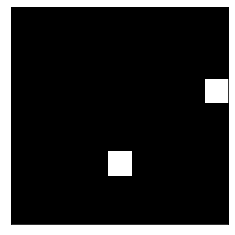

In [26]:
# @title generate dataset {vertical-output: true }
sequences = np.zeros((num_sequences, steps_per_sequence, grid_size, grid_size))
batch = init_grids(grid_size,num_sequences)

for i in range(steps_per_sequence):
  sequences[:,i,:,:] = batch
  batch = model(batch, beta)
np.save("./sequence_data", sequences)
visualize_sequence(sequences[np.random.randint(0,num_sequences)], framerate=0.1)
dataset = chop_and_shuffle_data(sequences)
np.save("./dataset", dataset)
print(dataset.shape)

## Summary statistics for the PCA

In order to perform PCA, we need to define a set of summary statistics $S(.)$ for the samples produced by the PCA model. Here, we have to make a few choices that will impact the performance of the ABC algorithms.

Our dataset $D = \{x_i, y_i\}_{i=1}^N$ consists of $N$ pairs of grid states. Each pair represents the transition of a grid from a state $x_i$ at a time step $t$ to a state $y_i$ at time step $t+1$. The PCA model takes as input a grid state, simulates a time step for it, and returns the resulting state.

**1. Count the number of newly activated cells**

Our first summary statistic can be to simply count the number of cells transitioning from $x_{ij}^{(n)}= 0$ to $y_{ij}^{(n)}= 1$ for $n=1,\dots,N$.

**2. Collect the indices of the newly activated cells**

The second possible statistic is a collection of the indices of all cells that have changed state between $x_{ij}$ and $y_{ij}$. This allows e.g. to define the distance function as a pixel-wise loss function. 



In [28]:
# @title define summary statistics functions
def S1(X:np.ndarray, Y:np.ndarray) -> float:
  return jnp.sum((1-X)*Y, axis=(-1,-2))

def S2(X:np.ndarray, Y:np.ndarray) -> float:
  return (1-X)*Y

## Distance functions

In order to perform ABC, we need to define a distance function $\rho(S(x_{sim}), S(x_{obs}))$ based on the summary statistics $S(.)$. 

**1. mean squared difference in newly activated cells**

**2. Sum of pixel-wise losses**

In [29]:
# @title define distance functions
def calc_distance_V1(X, Y_sim:np.ndarray, Y_obs:np.ndarray) -> float:
  # get statistics of the simulated set
  s_sim = S1(X, Y_sim)
  # get statistics of the observed set
  s_obs = S1(X, Y_obs)
  # calculate the mean difference
  return jnp.mean(jnp.square(s_sim - s_obs))

def calc_distance_V2(X, Y_sim:np.ndarray, Y_obs:np.ndarray) -> float:
  # get statistics of the simulated set
  s_sim = S1(X, Y_sim)
  # get statistics of the observed set
  s_obs = S1(X, Y_obs)
  # calculate the mean ratio
  return (1 - jnp.mean(s_sim / (s_obs+1)))**2

In [30]:
X = dataset[:,0]
Y_obs = dataset[:,1]
Y_sim = model(X, 0.8)
calc_distance_V1(X, Y_sim, Y_obs)

DeviceArray(304.85947, dtype=float32)

In [31]:
X = dataset[:,0]
Y_obs = dataset[:,1]
Y_sim = model(X, 0.08)
calc_distance_V2(X, Y_sim, Y_obs)

DeviceArray(0.03147093, dtype=float32)

## Estimate $\beta$ via ABC-REJ

We define:

- $\epsilon = 0.005$ 
- $p(\theta) \sim U(0,1)$

In [32]:
# @title define helpers
def sample_from_prior(size:int):
  return np.random.uniform(0,1,size)

In [33]:
# @title define a rejection sampler function
def ABC_REJ(X:np.ndarray, Y_obs:np.ndarray, epsilon:float) -> float:
  num_steps = 1
  beta = None
  while True:
    beta = sample_from_prior(1)
    Y_sim = model(X, beta)
    distance = calc_distance_V2(X, Y_sim, Y_obs)
    if distance <= epsilon:
      break
    else:
      num_steps += 1
  return beta, num_steps

In [34]:
# @title use ABC-REJ to draw approximate samples from the posterior  { vertical-output: true}
samples = []
required_steps = []
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilon = 0.1

# In the paper, 1,000 accepted samples are drawn
for i in tqdm(range(1000)):
  sample, num_steps = ABC_REJ(X, Y_obs, epsilon)
  samples.append(sample)
  required_steps.append(num_steps)

print(f"\n average # steps for acceptance: {np.mean(required_steps)}")




100%|██████████| 1000/1000 [10:21<00:00,  1.61it/s]

average # steps for acceptance: 14.296


Text(0, 0.5, 'density')

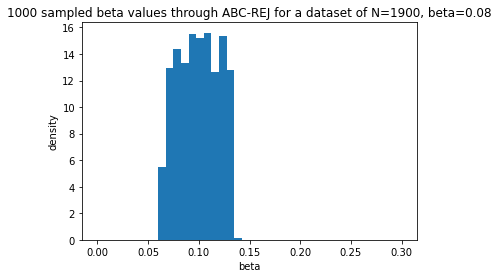

In [35]:
# @title histogram of the samples {vertical-output: true}
n, bins, _ = plt.hist(np.array(samples).squeeze(-1), density=True, range=(0,0.3), bins=40)
plt.title("1000 sampled beta values through ABC-REJ for a dataset of N=1900, beta=0.08")
plt.xlabel("beta")
plt.ylabel("density")

## Estimate $\beta$ via ABC-MCMC

We define:

- $\epsilon = 0.005$ 
- $\beta_0 = 0.5$
- $q(\theta|\theta_t) \sim \mathcal{N}(\theta_t, 0.15^2)$


In [36]:
# @title define helpers
def sample_from_prior(size:int):
  return np.random.uniform(0,1,size)

# @title Helper Functions
def gaussian_pdf(mu:float, sigma_sq:float) -> Callable:
  def pdf(x:float) -> float:
    return (1/(np.sqrt(2*np.pi)*np.sqrt(sigma_sq)))*np.exp(-(x-mu)**2/(2*sigma_sq))
  return pdf

def q(mu:float, sigma) -> float:
  return np.random.normal(mu, sigma)

def gauss_likelihood(x, y, sigma):
  """
  Calculate the likelihood of x as p(x|y) ~ N(y|sigma_sq)
  """
  pdf = gaussian_pdf(y, sigma)
  return pdf(x)

def uniform_likelihood(low:float, high:float, x:float) -> float:
  """
  Calculate the likelihood of x as p(x) ~ U(low, high)
  """
  if x > high or x < low:
    return 0 
  else:
    return 1 / (high-low)

def calc_alpha(beta_star:float, beta:float, epsilon:float, dist:float, sigma:float) -> float:
  if dist <= epsilon and uniform_likelihood(0, 1, beta_star) > 0:
    return min([1,gauss_likelihood(beta, beta_star, sigma)/gauss_likelihood(beta_star, beta, sigma)])
  else:
    return 0

In [37]:
# @title Define ABC-MCMC
def ABC_MCMC(X:np.ndarray, Y_obs:np.ndarray, N:int, epsilon:float, beta:float, proposal_sigma:float) -> List[float]:
  betas = [beta]
  for i in tqdm(range(N)):
    beta_star = q(beta, proposal_sigma)
    Y_sim = model(X, beta_star)
    dist = calc_distance_V2(X, Y_sim, Y_obs)
    alpha = calc_alpha(beta_star, beta, epsilon, dist, proposal_sigma)
    if random.random() <= alpha:
      beta = beta_star
      betas.append(beta)
  return betas

100%|██████████| 10000/10000 [07:26<00:00, 22.42it/s]

accepted 1748 samples


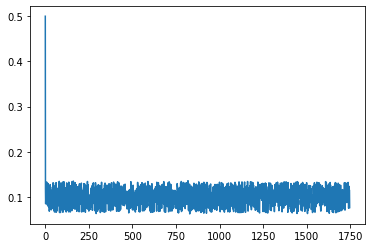

In [38]:
# @title Run ABC-MCMC for the example { vertical-output: true}
N = 10000
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilon = 0.1
beta_init = 0.5
proposal_sigma = 0.15

betas = ABC_MCMC(X, Y_obs, N, epsilon, beta_init, proposal_sigma)

print(f"accepted {len(betas)} samples")

plt.plot(np.arange(len(betas)), betas)

Text(0, 0.5, 'density')

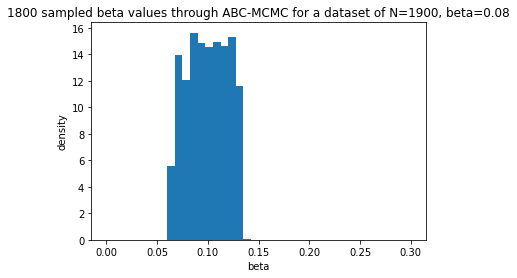

In [39]:
# @title histogram of the samples {vertical-output: true}
n, bins, _ = plt.hist(betas, density=True, range=(0,0.3), bins=40)
plt.title("1800 sampled beta values through ABC-MCMC for a dataset of N=1900, beta=0.08")
plt.xlabel("beta")
plt.ylabel("density")